In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D  ,Activation
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

In [47]:
train = pd.read_csv("digits/train.csv")
test = pd.read_csv("digits/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

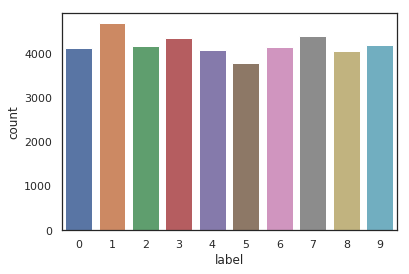

In [48]:
Y_train=train['label']
X_train=train.drop(labels=['label'],axis=1) 
sns.countplot(Y_train)
Y_train.value_counts()

In [49]:
X_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
X_train.isnull().any().sum()

0

In [51]:
test.isnull().any().sum()

0

In [52]:
X_train = X_train / 255.0
test = test / 255.0

In [53]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [54]:
X_train.shape

(42000, 28, 28, 1)

In [55]:
Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels.
MNIST images are gray scaled so it use only one channel. 
For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

SyntaxError: invalid syntax (<ipython-input-55-2ce509635b47>, line 1)

In [56]:
#We need to encode these lables to one hot vectors
Y_train = to_categorical(Y_train, num_classes = 10)

In [57]:
Y_train.shape

(42000, 10)

In [58]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=42)

In [72]:
from keras.layers.normalization import BatchNormalization

model=Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [73]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [74]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_30 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
activation_19 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 22, 22, 32)        9248      
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 20, 20, 32)        9248      
_________________________________________________________________
batch_normalization_31 (Batc (None, 20, 20, 32)        128       
__________

In [75]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [76]:
epochs = 1 # increase the no of epochs
batch_size = 86

In [77]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images



In [78]:
datagen.fit(X_train)

In [ ]:
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])